In [10]:
#Loading in libraries
pacman::p_load(tidyverse, dplyr, ggplot2, gganimate, ggthemes, RColorBrewer, fastDummies, janitor, cowplot, MLmetrics,
               repr, BBmisc, devtools, reticulate, Rcpp, tictoc, data.table, corrplot, ggrepel, tensorflow, keras, bsts)

#Loading in train data
df_train <- read.csv("../input/tabular-playground-series-sep-2022/train.csv")

# What's the data like?

In [11]:
head(df_train)

,row_id,date,country,store,product,num_sold
,<int>,<chr>,<chr>,<chr>,<chr>,<int>
1,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
2,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
3,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
4,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
5,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
6,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187


In [12]:
summary(df_train[, length(df_train)])

df_train %>%
    mutate(across(c(3:5), as.factor)) %>%
    str()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   19.0    95.0   148.0   194.3   283.0   986.0 

'data.frame':	70128 obs. of  6 variables:
 $ row_id  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ date    : chr  "2017-01-01" "2017-01-01" "2017-01-01" "2017-01-01" ...
 $ country : Factor w/ 6 levels "Belgium","France",..: 1 1 1 1 1 1 1 1 2 2 ...
 $ store   : Factor w/ 2 levels "KaggleMart","KaggleRama": 1 1 1 1 2 2 2 2 1 1 ...
 $ product : Factor w/ 4 levels "Kaggle Advanced Techniques",..: 1 3 4 2 1 3 4 2 1 3 ...
 $ num_sold: int  663 615 480 710 240 187 158 267 610 463 ...


There are 6 countries, 2 stores and 4 products. Let's try and figure out how they interact with each other. Are the time series correlated or cointegrated? Does the trend vary from country to country?

In [13]:
#Creating  time grouping variables
df_train <- df_train %>%
  cbind("day" = as.numeric(format.Date(df_train$date, "%d"))) %>%
  cbind("month" = as.numeric(format.Date(df_train$date, "%m"))) %>%
  cbind("year" = as.numeric(format.Date(df_train$date, "%Y"))) %>%
  cbind("weekday" = weekdays(as.Date(df_train$date, "%Y-%m-%d")))

df_train <- df_train %>%
   mutate(day = factor(day, levels = c(as.character(1:31))),
          month = factor(month, levels = c(as.character(1:12))),
          weekday = factor(weekday, levels = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")))

I decided to reuse a function from a previous competition (with little tweaks):

grouping_plotter(dataset, group_list, groupby_time, groupdistinct) - function that allows the choice and grouping of plotted variables:

* dataset - data.frame object
* group_list - list of vectors with variable names (e.g. for this competition):

1. country - whether to plot number of sold books based on the country ('Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain')
2. store -  whether to plot number of sold books based on the store ('KaggleMart', KaggleRama')
3. product - whether to plot how well a particular product is selling ('Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose')

* groupby_time - grouping based on the time of the year e.g.:
1. day - mean of each day throughout  '30' / '31' day months in the series
2. weekday - mean of each 'day-of-the-week' throughout the series
3. month - mean of each month in a year

* groupdistinct -  which groups should be the focal point of the plot and what distinction to draw between them - first element decides the division between subgroups


* makegrid - to compare two groups in a grid, instead of a single plot - **makegrid uses groups from groupdistinct argument. Moreover the order of groups in the groupdistinct agument dictates the layout of the grid - first element will be treated as rows and second as columns.**

In [57]:
grouping_plotter <- function(dataset, group_list, groupby_time, groupdistinct, makegrid = NULL) {

    
#Filtering chosen variables
for(i in 1:3) {
    dataset <- dataset %>%
        filter(dataset[[i]] %in% unlist(group_list[i]))
}

#Changing char variables into factors
dataset <- dataset %>%
    mutate(across(c(1:3), as.factor))
    
#Grouping variables and extracting congestion values based on chosen period
dataset <- dataset %>%
    group_by_at(vars(all_of(groupby_time), all_of(groupdistinct))) %>%
    mutate(num_sold_mean = mean(num_sold))


#Checking whether to create a grid    
if(is.null(makegrid) || makegrid == FALSE) {

    #Creating a joint grouping variable
    dataset <- dataset %>%
      unite(col = grouping, all_of(groupdistinct)) %>% 
      arrange(grouping) %>%
      mutate(grouping = as.factor(grouping))

    dataset <- dataset %>%
      distinct(num_sold_mean, .keep_all = TRUE)

    #Changing the opacity of grid lines - 4th value is the 'alpha'
    col_grid <- rgb(235, 235, 235, 190, maxColorValue = 255)


    #Creating the plot
    options(repr.plot.width = 14, repr.plot.height = 8)
    timely_plot <- ggplot(dataset, aes(x = dataset[[groupby_time]], y = num_sold_mean,
                                       color = grouping,  group = grouping)) +
        geom_line(size = 1.75) + theme_gdocs() + xlab(str_to_title(groupby_time)) +
        scale_color_brewer(palette = "Spectral") + theme(panel.grid.major = element_line(color = col_grid),
                                                     legend.text = element_text(colour="black", size=10))
    
     #Printing created plot
     timely_plot
                                        } else if(!is.null(makegrid) && makegrid == TRUE) {

        #Removing unneeded data
        dataset <- dataset[, c(all_of(groupdistinct),all_of(groupby_time), 'num_sold_mean')] %>%
            distinct()

    
        # Creating the plot
        options(repr.plot.width = 18, repr.plot.height = 14)
        timely_plot <- ggplot(dataset, aes(x = dataset[[groupby_time]], y = num_sold_mean, group = 1,
                                           color = eval(parse(text = groupdistinct[[2]])))) +
            xlab(label = str_to_title(groupby_time)) +
            geom_line(size = 1.4) +
            theme_hc()  +
            scale_color_brewer(palette = "Spectral") + theme(
                                                         legend.text = element_text(colour="black", size = 10),
                                                         axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 1),
                                                         axis.title.x = element_text(margin = margin(t = 30))) + 
            labs(colour=groupdistinct[[2]])
    

        timely_plot + facet_grid(dataset[[groupdistinct[[1]]]]~dataset[[groupdistinct[[2]]]])

                                                                                        }

}

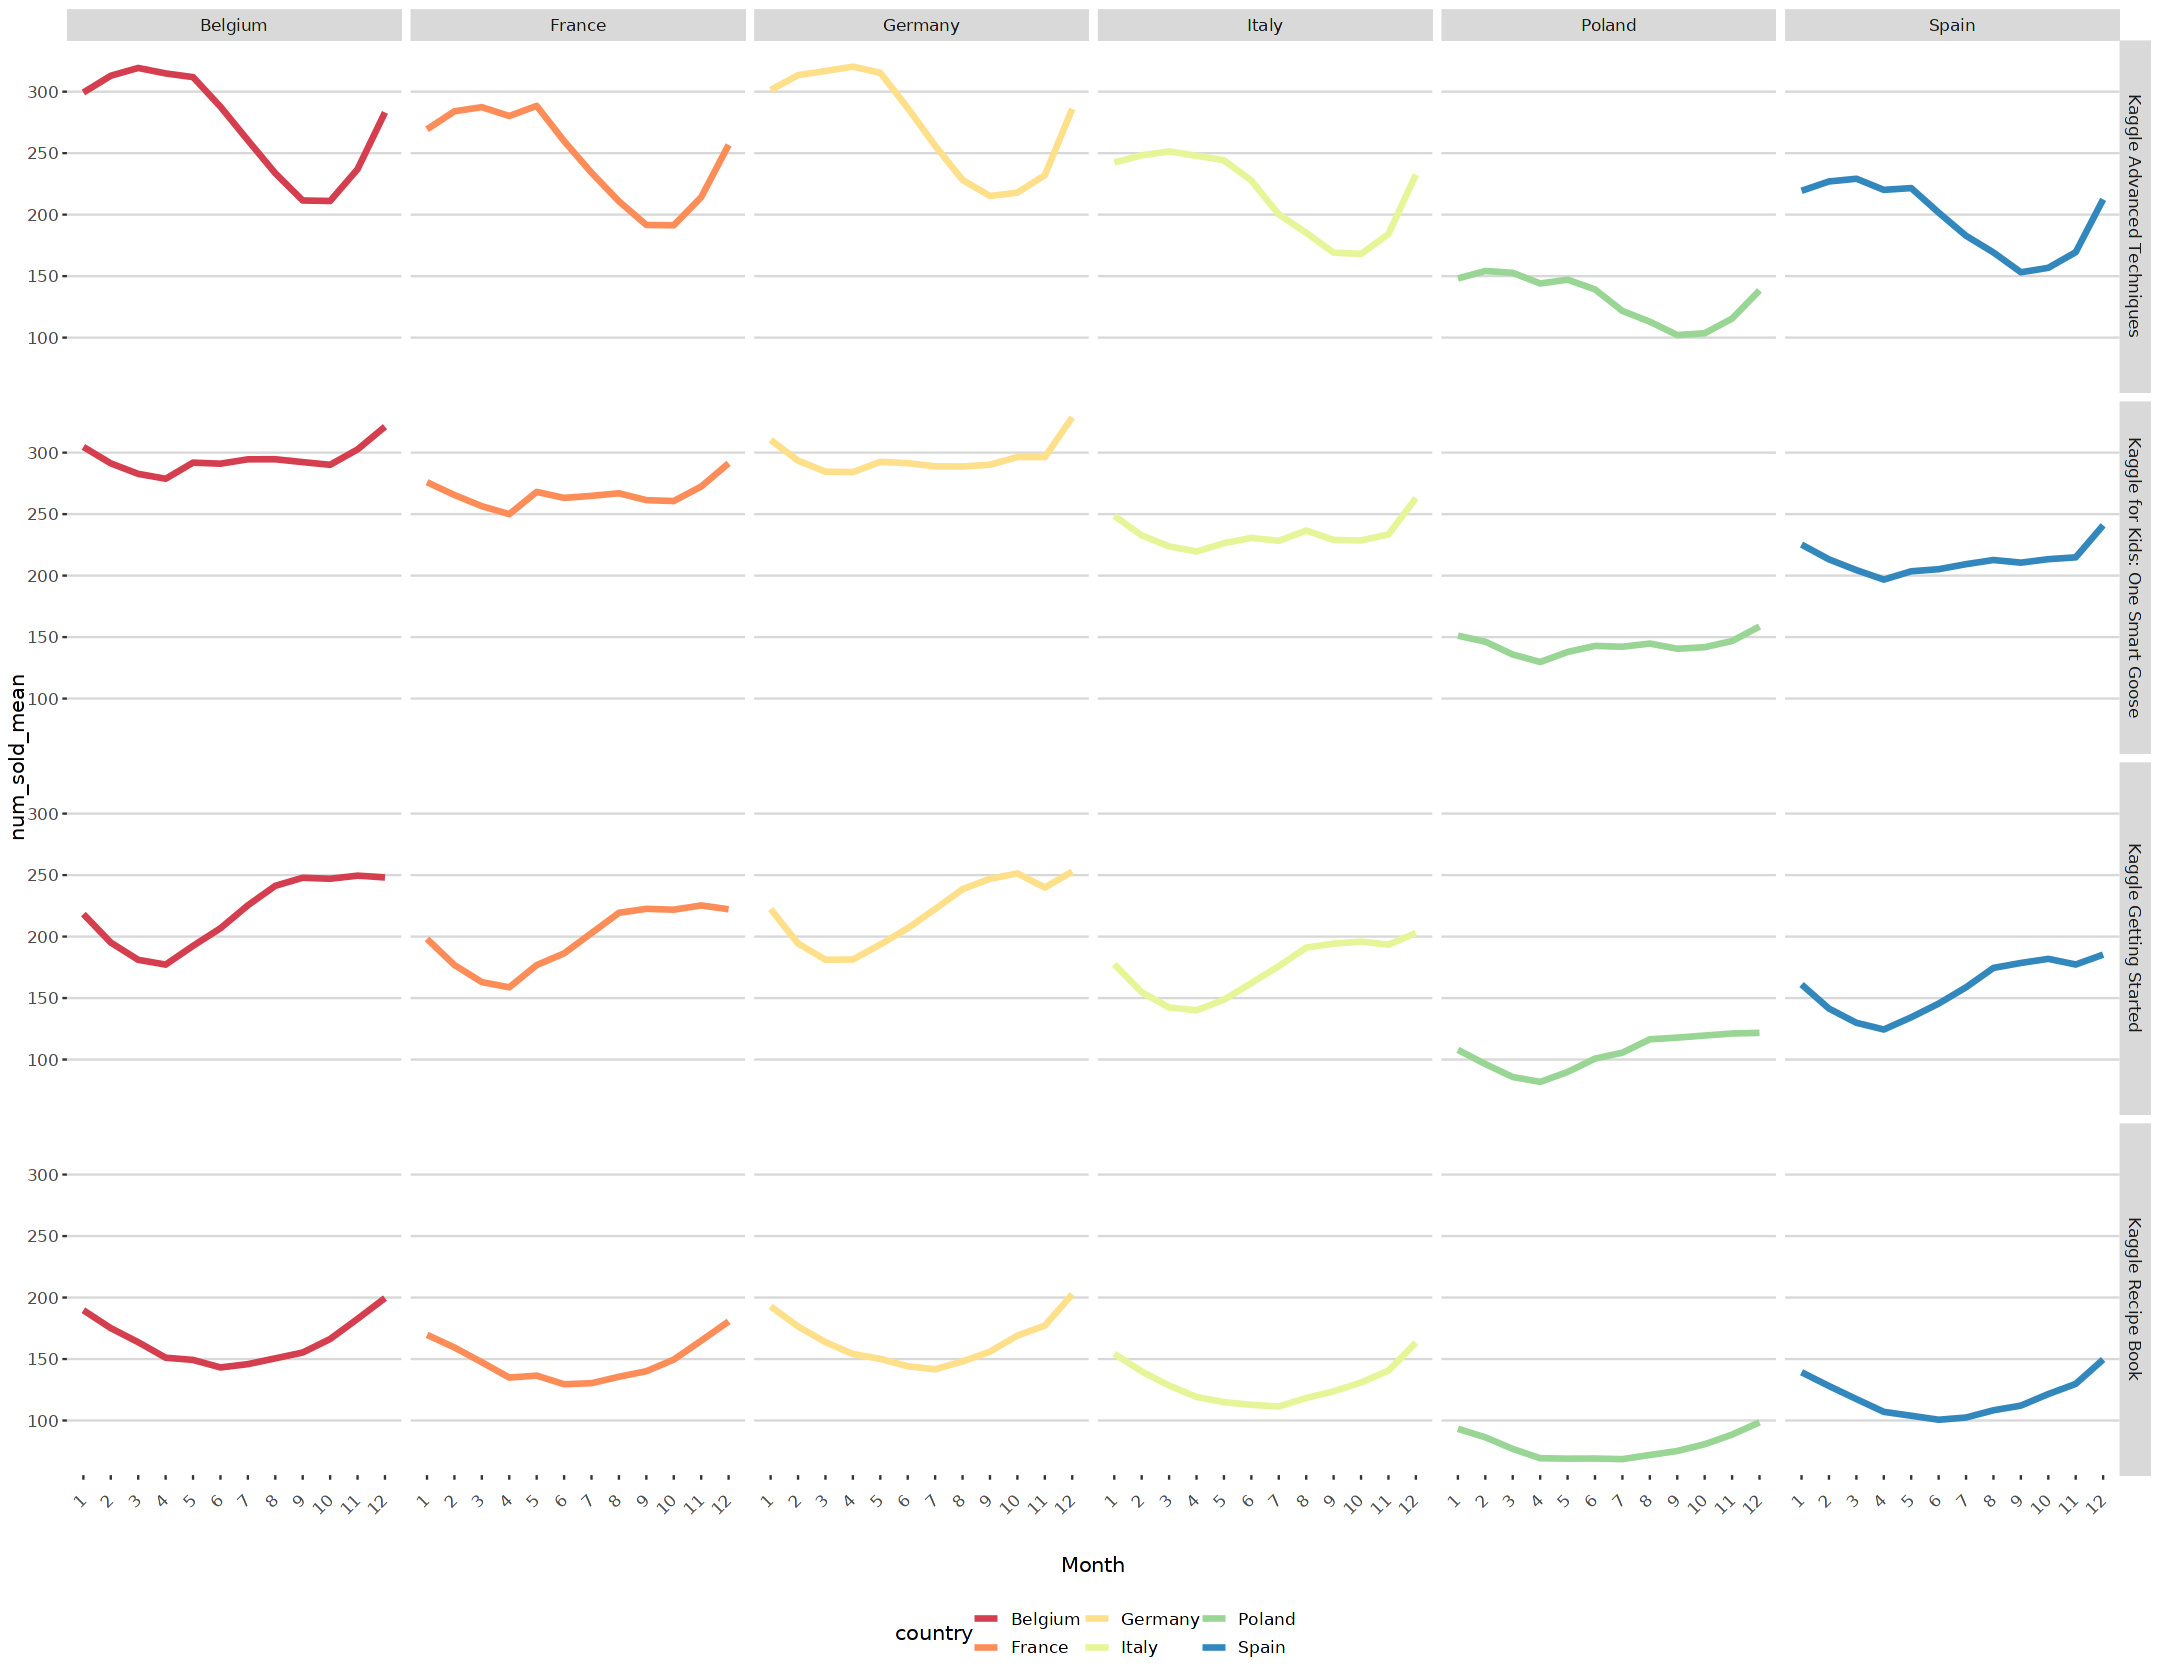

In [50]:
grouping_plotter(df_train[, -c(1:2)],
                group_list = list(c('Poland', 'Spain', 'Italy', 'Germany', 'France','Belgium'),
                c('KaggleMart', 'KaggleRama'),
                c('Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book',
                  'Kaggle for Kids: One Smart Goose', 'Kaggle Advanced Techniques', 'Kaggle Getting Started')),
                groupby_time = c("month"),
                groupdistinct = c('product','country'),
                makegrid = TRUE)

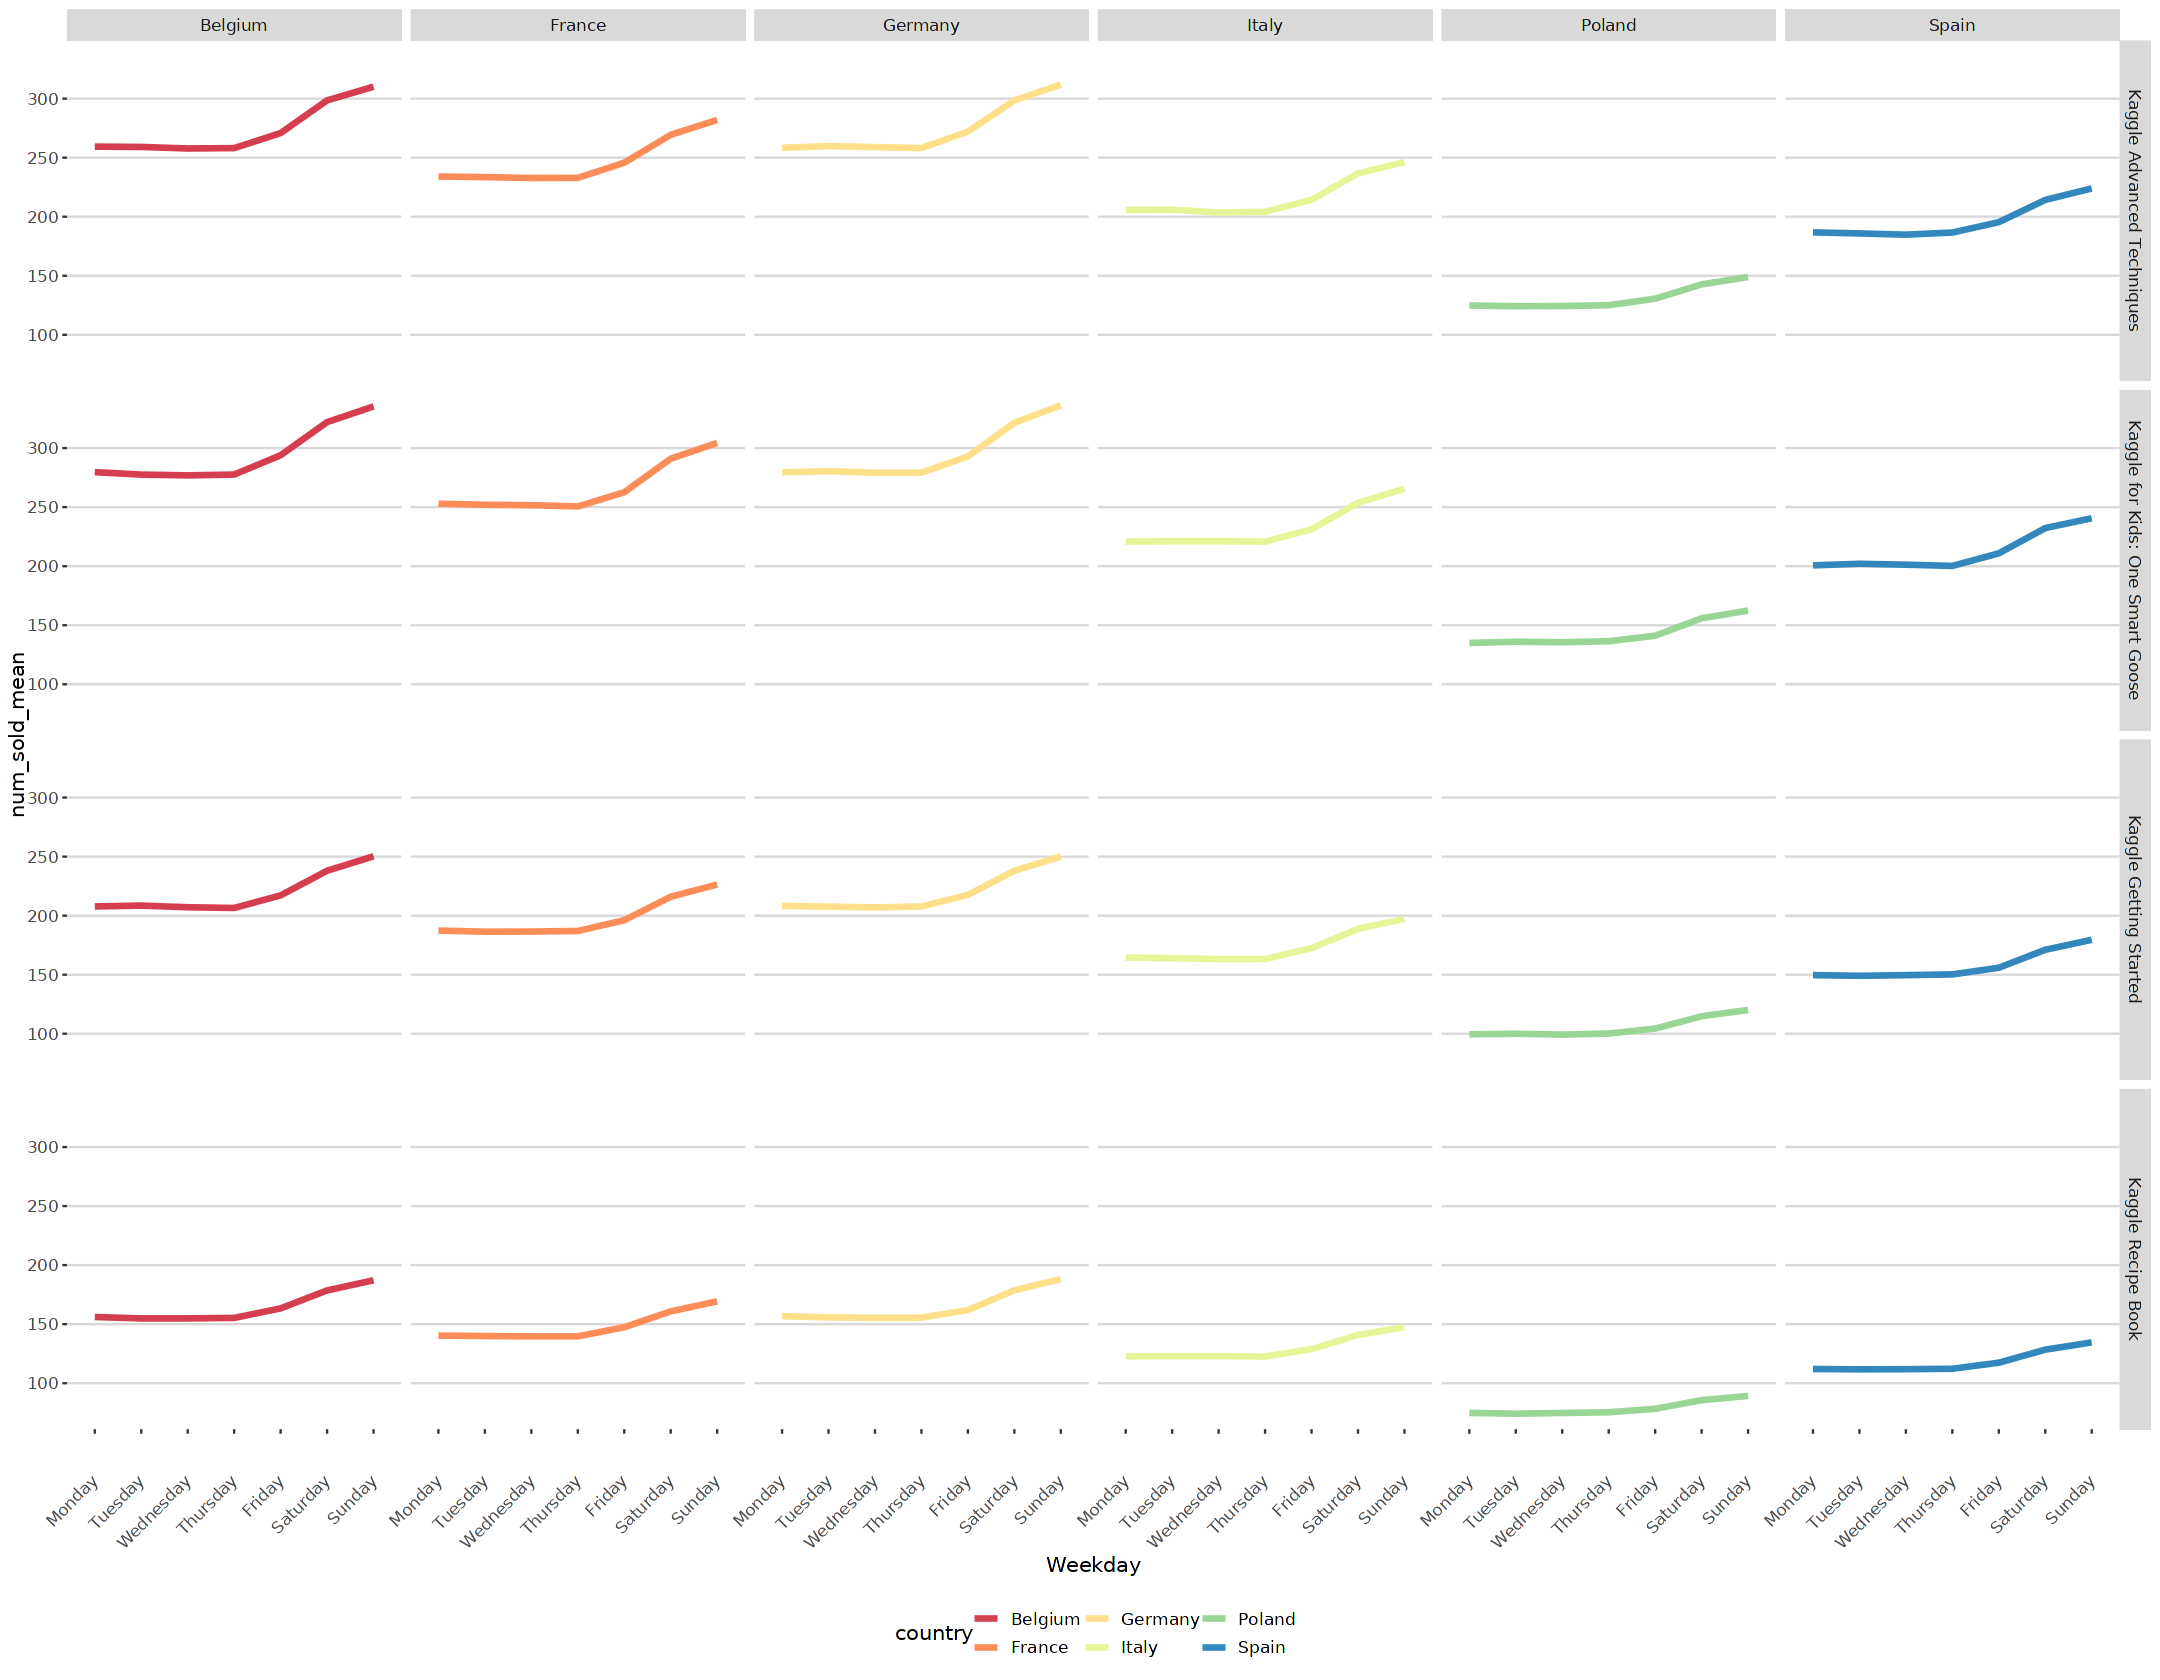

In [52]:
grouping_plotter(df_train[, -c(1:2)],
                group_list = list(c('Poland', 'Spain', 'Italy', 'Germany', 'France','Belgium'),
                c('KaggleMart', 'KaggleRama'),
                c('Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book',
                  'Kaggle for Kids: One Smart Goose', 'Kaggle Advanced Techniques', 'Kaggle Getting Started')),
                groupby_time = c("weekday"),
                groupdistinct = c('product','country'),
                makegrid = TRUE)

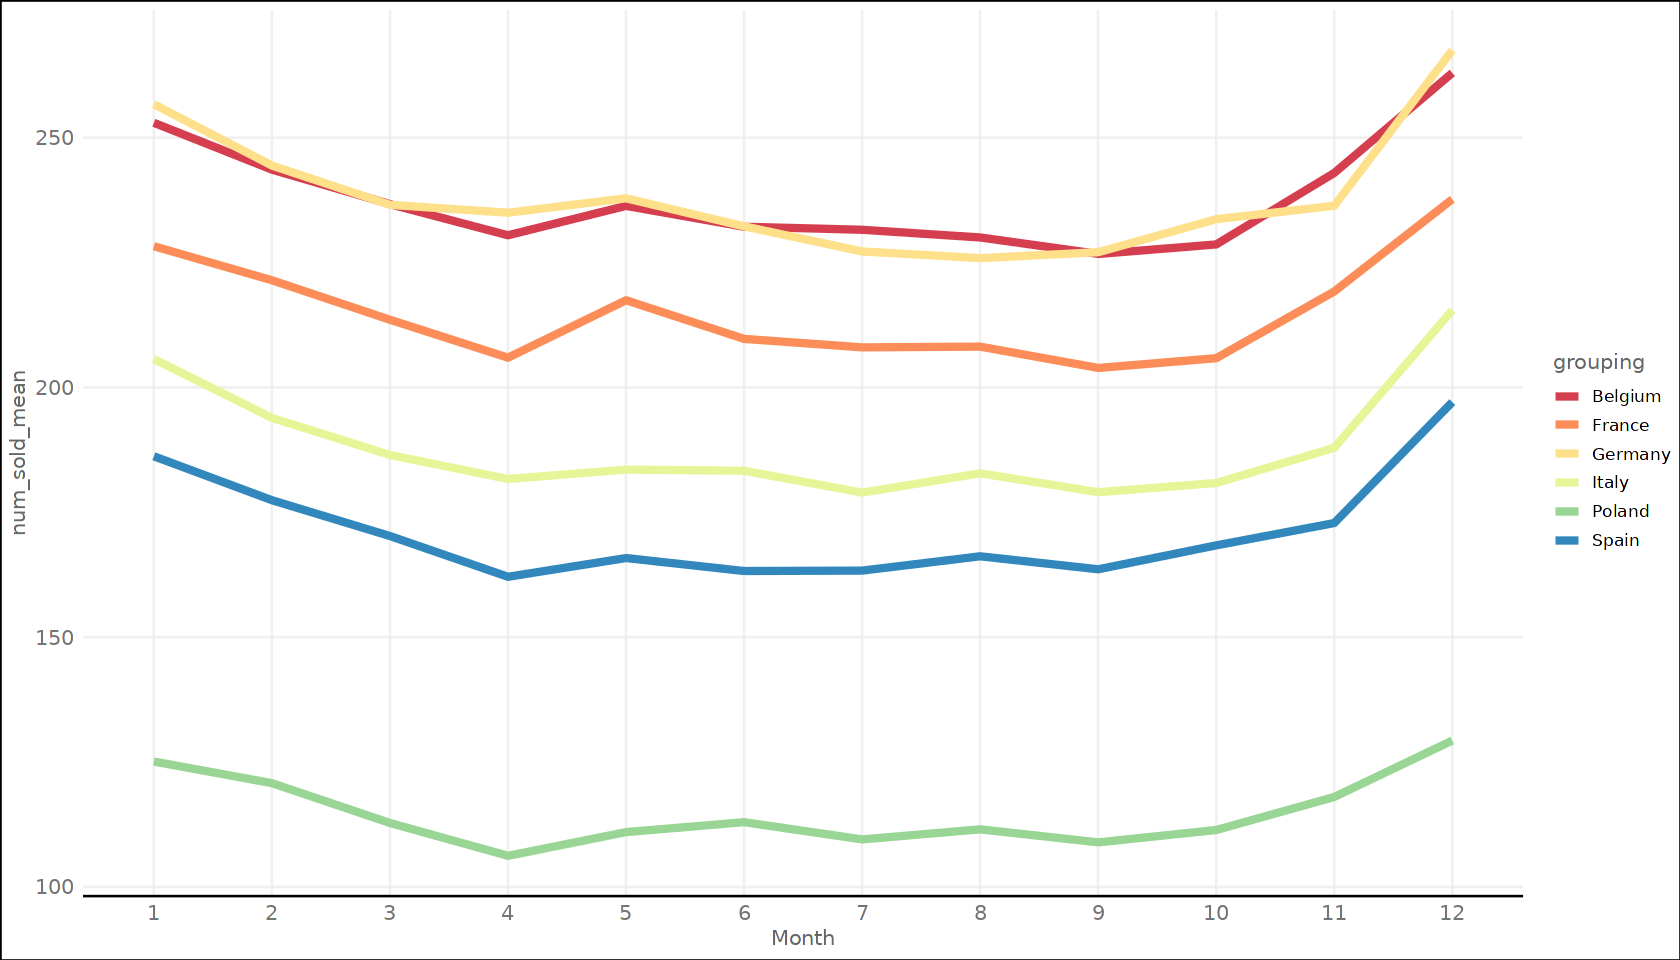

In [61]:
grouping_plotter(df_train[, -c(1:2)],
                group_list = list(c('Poland', 'Spain', 'Italy', 'Germany', 'France','Belgium'),
                c('KaggleMart', 'KaggleRama'),
                c('Kaggle Advanced Techniques', 'Kaggle Getting Started', 'Kaggle Recipe Book',
                  'Kaggle for Kids: One Smart Goose', 'Kaggle Advanced Techniques', 'Kaggle Getting Started')),
                groupby_time = c("month"),
                groupdistinct = c('country'),
                makegrid = FALSE)